In [2]:
#svm
import menpo.io as mio
import os
from sklearn import svm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import math
import Models
from Models import ChangeVector, ImageData
path_to_svm_training_database = '/home/lee/dataset/CK+/aam-images/**/**/**/*'
# path_to_svm_training_database = '/Programing/GR/Code/CK+/aam-images/**/**/**/*'
import pickle


def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def process(image, crop_proportion=0.3, max_diagonal=400):
    if image.n_channels == 3:
        image = image.as_greyscale()
    image = image.crop_to_landmarks_proportion(crop_proportion)
    d = image.diagonal()
    if d > max_diagonal:
        image = image.rescale(float(max_diagonal) / d)
    return image

#process changingVector, reduce dimension from 2x68 to 1x68, by process PCA
def pca(changeVector):
    X = np.array(changeVector)
    pca_model = PCA(n_components=1)
    return pca_model.fit_transform(X)

#chuan hoa theo max tung landmark
def landmark_normalize(landmark):
    vector_max = 0
    for p in landmark:
        if(math.sqrt(float(p[0])*float(p[0]) + float(p[1])*float(p[1])) > vector_max):
            vector_max = math.sqrt(p[0]*p[0] + p[1]*p[1])
    for p in landmark:
        p[0] = p[0]/float(vector_max)
        p[1] = p[1]/float(vector_max)
    return landmark


def rolate(vector, angle):
    rx = vector[0]*(math.cos(angle)) - vector[1]*(math.sin(angle))
    ry = vector[0]*(math.sin(angle)) + vector[1]*(math.cos(angle))
    return [rx, ry]

#chuan hoa mang 68 diem landmark cua perk state theo neutral state
def normalize_perk_landmark(landmark_perk, landmark_neutral):
    neutral_center = landmark_neutral[30]
    perk_center = landmark_perk[30]
#     for lm in landmark_perk:
    #move perk landmark to match center of neutral landmark
    move_vector = [neutral_center[0] - perk_center[0], neutral_center[1] - perk_center[1]]
    for lm in landmark_perk:
        lm[0] += move_vector[0]
        lm[1] += move_vector[1]
    
    #scale the size of detected perk landmark based on neutrol landmark 27 to 30 (the nose)
    scale_neutral = [landmark_neutral[30][0] - landmark_neutral[27][0], landmark_neutral[30][1] - landmark_neutral[27][1]]
    scale_perk = [landmark_perk[30][0] - landmark_perk[27][0], landmark_perk[30][1] - landmark_perk[27][1]]
    ratio = math.sqrt(scale_neutral[0]*scale_neutral[0] + scale_neutral[1]*scale_neutral[1])/math.sqrt(scale_perk[0]*scale_perk[0]+scale_perk[1]*scale_perk[1]) 
    for lm in landmark_perk:
        lm[0] = (perk_center[0] - lm[0]) * (1 - ratio) + lm[0]
        lm[1] = (perk_center[1] - lm[1]) * (1 - ratio) + lm[1]
    
    #rolate the mask of perk to match neutral
    sign_y = scale_perk[0]*scale_neutral[1] - scale_perk[1]*scale_neutral[0]
    sign_x = scale_perk[0]*scale_neutral[0] + scale_perk[1]*scale_neutral[1]
    angle = math.atan2(sign_y, sign_x)
    for lm in landmark_perk:
        tmp_vector = [lm[0] - landmark_perk[30][0],lm[1] - landmark_perk[30][1]]
        new_vector = rolate(tmp_vector, angle)
        lm[0] = new_vector[0] + landmark_perk[30][0]
        lm[1] = new_vector[1] + landmark_perk[30][1]
        
    return landmark_perk

#normalize set2 using set1 as base
def coopNormalize(set1, set2):
    len1 = len(set1)
    len2 = len(set2)
    merged = set1 + set2
    normalized = normalize(merged, norm='max', axis=0)
    result = []
    for i in range(len1, len1 + len2):
        result.append(normalized[i])
    return result

#import images
training_images = mio.import_images(path_to_svm_training_database, verbose=True)
training_images = training_images.map(process)

path_to_facs = '/home/lee/dataset/CK+/FACS/'
# path_to_facs = '/Programing/GR/Code/CK+/FACS/'
path_to_emotions = '/home/lee/dataset/CK+/Emotion/'
# path_to_emotions = '/Programing/GR/Code/CK+/Emotion/'

#create training data

#check if example is labeled
labeled_subject = []
emotion_subject = os.listdir(path_to_emotions)
for subject in emotion_subject:
    session = os.listdir(path_to_emotions + "/" + subject)
    for s in session:
        labeled_subject.append(subject + "-" + s)

count = 0;
svm_training_data = []
while(count < len(training_images)):
    file_path = str(training_images[count].path).split("/")
#     print(file_path)
    facs_path = path_to_facs + file_path[6] + '/' + file_path[7]
    gt_emotion = -1
    
    #get emotion label from Emotion Folder
    emotion_checker = file_path[6] + "-" + file_path[7]
    if(emotion_checker in  labeled_subject):
        emotion_path = path_to_emotions + file_path[6] + '/' + file_path[7]
        if(len(os.listdir(emotion_path)) != 0):
            emotion_path = emotion_path + '/' + os.listdir(emotion_path)[0]
            fi = open(emotion_path)
            for line in fi:
                if(line.split()):
                    gt_emotion = int(float(line.split()[0]))
#                 print(emotion_path + ":" + str(gt_emotion))
            fi.close()
    
    #get facs from FACS folder
    facs_path = facs_path + '/' + os.listdir(facs_path)[0]
    fi = open(facs_path, 'r')
    data_facs = {}
    tmp = []
    for line in fi: # read rest of lines
        if(line.split()):
            tmp.append(line.split())
    for f in tmp:
        data_facs[str(int(float(f[0])))] = int(float(f[1]))
    fi.close()
    
    landmark = []
    landmark_neutral = training_images[count].landmarks['PTS'].lms.points
    landmark_perk = training_images[count + 1].landmarks['PTS'].lms.points
    landmark_perk = normalize_perk_landmark(landmark_perk, landmark_neutral)
    for i in range(0,68):
        landmark.append([landmark_perk[i][0] - landmark_neutral[i][0], landmark_perk[i][1] - landmark_neutral[i][1]])

#     svm_training_data.append(ChangeVector(data_facs, landmarkChange, gt_emotion))   

    svm_training_data.append(ImageData(data_facs, landmark, gt_emotion))
    count = count + 2
    

facs = []
#create facs array
for data in svm_training_data:
    for facs_code in data.facs:
        if((int(facs_code)) not in facs):
            facs.append(int(facs_code))
facs.sort()

#create testing data
svm_testing_data = []
path_to_svm_testing_database = "/home/lee/dataset/CK+/test-aam-images/**/**/**/*"
# path_to_svm_testing_database = "/Programing/GR/Code/CK+/test-aam-images/**/**/**/*"
testing_images = mio.import_images(path_to_svm_testing_database, verbose=True)
testing_images = testing_images.map(process)

count = 0;
while(count < len(testing_images)):
    file_path = str(testing_images[count].path).split("/")
#     print(file_path)
    facs_path = path_to_facs + file_path[6] + '/' + file_path[7]
    gt_emotion = -1
    
    #get emotion label from Emotion Folder
    emotion_checker = file_path[6] + "-" + file_path[7]
    if(emotion_checker in  labeled_subject):
        emotion_path = path_to_emotions + file_path[6] + '/' + file_path[7]
        if(len(os.listdir(emotion_path)) != 0):
            emotion_path = emotion_path + '/' + os.listdir(emotion_path)[0]
            fi = open(emotion_path)
            for line in fi:
                if(line.split()):
                    gt_emotion = int(float(line.split()[0]))
#                 print(emotion_path + ":" + str(gt_emotion))
            fi.close()
    
    
    #get facs from FACS folder
    facs_path = facs_path + '/' + os.listdir(facs_path)[0]
    fi = open(facs_path, 'r')
    data_facs = {}
    tmp = []
    for line in fi: # read rest of lines
        if(line.split()):
            tmp.append(line.split())
    for f in tmp:
        data_facs[str(int(float(f[0])))] = int(float(f[1]))
    fi.close()
    
    landmark = []
    landmark_neutral = testing_images[count].landmarks['PTS'].lms.points
    landmark_perk = testing_images[count + 1].landmarks['PTS'].lms.points
    landmark_perk = normalize_perk_landmark(landmark_perk, landmark_neutral)
    for i in range(0,68):
        landmark.append([landmark_perk[i][0] - landmark_neutral[i][0], landmark_perk[i][1] - landmark_neutral[i][1]])
    
#     svm_testing_data.append(ChangeVector(data_facs, landmarkChange, gt_emotion))   
    svm_testing_data.append(ImageData(data_facs, landmark, gt_emotion))
    count = count + 2


Found 1030 assets, index the returned LazyList to import.
Found 156 assets, index the returned LazyList to import.


[array([142.89449631, 138.53144188]), array([ 75.63386036, 135.47960819])]
[array([132.02180805, 137.68873766]), array([ 72.04816968, 135.94603658])]
---
[array([132.02180805, 137.68873766]), array([ 72.04816968, 135.94603658])]
[array([132.02180805, 137.68873766]), array([ 72.04816968, 135.94603658])]


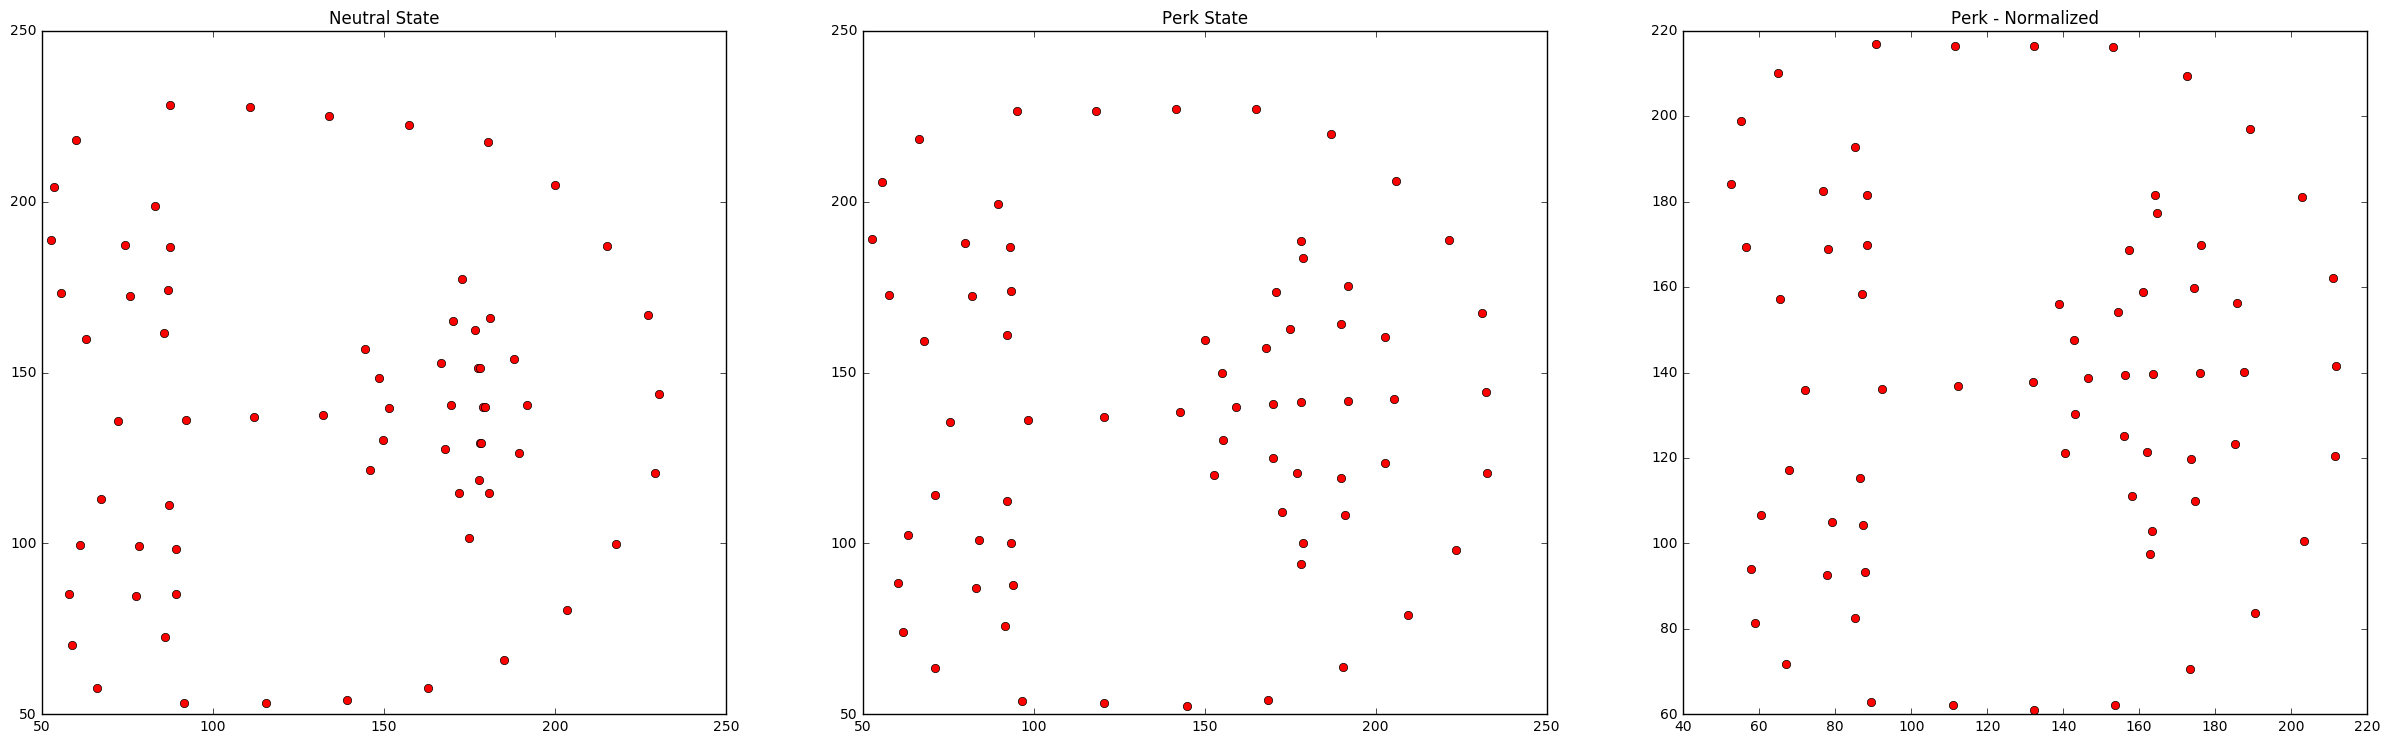

In [5]:
#test normalize perk
import matplotlib.pyplot as plt



def rolate(vector, angle):
    rx = vector[0]*(math.cos(angle)) - vector[1]*(math.sin(angle))
    ry = vector[0]*(math.sin(angle)) + vector[1]*(math.cos(angle))
    return [rx, ry]

#chuan hoa mang 68 diem landmark cua perk state theo neutral state
def normalize_perk_landmark(landmark_perk, landmark_neutral):
    neutral_center = landmark_neutral[30]
    perk_center = landmark_perk[30]
#     for lm in landmark_perk:
    #move perk landmark to match center of neutral landmark
    move_vector = [neutral_center[0] - perk_center[0], neutral_center[1] - perk_center[1]]
    for lm in landmark_perk:
        lm[0] += move_vector[0]
        lm[1] += move_vector[1]
    
    #scale the size of detected perk landmark based on neutrol landmark 27 to 30 (the nose)
    scale_neutral = [landmark_neutral[30][0] - landmark_neutral[27][0], landmark_neutral[30][1] - landmark_neutral[27][1]]
    scale_perk = [landmark_perk[30][0] - landmark_perk[27][0], landmark_perk[30][1] - landmark_perk[27][1]]
    ratio = math.sqrt(scale_neutral[0]*scale_neutral[0] + scale_neutral[1]*scale_neutral[1])/math.sqrt(scale_perk[0]*scale_perk[0]+scale_perk[1]*scale_perk[1]) 
    for lm in landmark_perk:
        lm[0] = (perk_center[0] - lm[0]) * (1 - ratio) + lm[0]
        lm[1] = (perk_center[1] - lm[1]) * (1 - ratio) + lm[1]
    
    #rolate the mask of perk to match neutral
    sign_y = scale_perk[0]*scale_neutral[1] - scale_perk[1]*scale_neutral[0]
    sign_x = scale_perk[0]*scale_neutral[0] + scale_perk[1]*scale_neutral[1]
    angle = math.atan2(sign_y, sign_x)
    for lm in landmark_perk:
        tmp_vector = [lm[0] - landmark_perk[30][0],lm[1] - landmark_perk[30][1]]
        new_vector = rolate(tmp_vector, angle)
        lm[0] = new_vector[0] + landmark_perk[30][0]
        lm[1] = new_vector[1] + landmark_perk[30][1]
        
    return landmark_perk


count = 2
landmark_neutral = testing_images[count].landmarks['PTS'].lms.points
landmark_perk = testing_images[count + 1].landmarks['PTS'].lms.points
plt.figure(figsize=(30,30))
plt.subplot(331)
x = []
y = []
# landmark_perk = normalize_perk_landmark(landmark_neutral, landmark_perk)
for lm in landmark_neutral:
    x.append(lm[0])
    y.append(lm[1])
plt.gca().set_title('Neutral State')
plt.plot(x,y, 'ro')

plt.subplot(332)
x = []
y = []
for lm in landmark_perk:
    x.append(lm[0])
    y.append(lm[1])
plt.gca().set_title('Perk State')
plt.plot(x,y, 'ro')

plt.subplot(333)
x = []
y = []
print([landmark_perk[30],landmark_perk[27]])
print([landmark_neutral[30], landmark_neutral[27]])
print('---')
landmark_perk = normalize_perk_landmark(landmark_perk, landmark_neutral)
print([landmark_perk[30],landmark_perk[27]])
print([landmark_neutral[30], landmark_neutral[27]])
for lm in landmark_perk:
    x.append(lm[0])
    y.append(lm[1])
plt.gca().set_title('Perk - Normalized')    
plt.plot(x,y, 'ro')

plt.show()



In [14]:
#emotion task - build training data
result = []
x_training = []
y_label = []

emotions = []
for data in svm_training_data:
    if(data.emotion != -1):
        tmp = []
        for vector in data.landmark:
            tmp.append(vector[0])
            tmp.append(vector[1])
        x_training.append(tmp)
        y_label.append(data.emotion)
        if(data.emotion not in emotions):
            emotions.append(data.emotion)
emotions.sort()

clf = svm.LinearSVC()
clf.fit(normalize(x_training, norm='max', axis=0), y_label)
print(clf.score(normalize(x_training, norm='max', axis=0), y_label))
# print(x_training[1])

1.0


In [15]:
#emotion task - multiclass SVM
x_testing = []
y_label = []
for data in svm_testing_data:
    if(data.emotion != -1):
        tmp = []
        for vector in data.landmark:
            tmp.append(vector[0])
            tmp.append(vector[1])
        x_testing.append(tmp)
        y_label.append(data.emotion)
print("Predicted Labels:")
print(clf.predict(coopNormalize(x_training, x_testing)))
print("Ground True Labels:")
print(y_label)
print("Score:")
print(clf.score(coopNormalize(x_training, x_testing), y_label))

Predicted Labels:
[3 7 1 5 2 6 4 1 3 5 7 6 1 5 7 1 3 7 6 1 5 1 1 7 1 4 3 5 7 3 5 7 6 3 5 6 7
 4 3 4 7 1 5 4 7 3 4 7 5 6 2 2 2 2 2 2]
Ground True Labels:
[3, 7, 1, 5, 7, 6, 4, 1, 3, 5, 7, 6, 1, 5, 7, 1, 3, 7, 6, 1, 5, 1, 1, 7, 1, 4, 3, 5, 7, 3, 5, 7, 6, 1, 5, 6, 7, 4, 3, 4, 7, 1, 5, 4, 7, 3, 4, 7, 5, 6, 2, 2, 2, 2, 2, 2]
Score:
0.9642857142857143


In [7]:
print(clf.predict([coopNormalize(x_training, x_testing)[4]]))

[2]


Found 7 assets, index the returned LazyList to import.


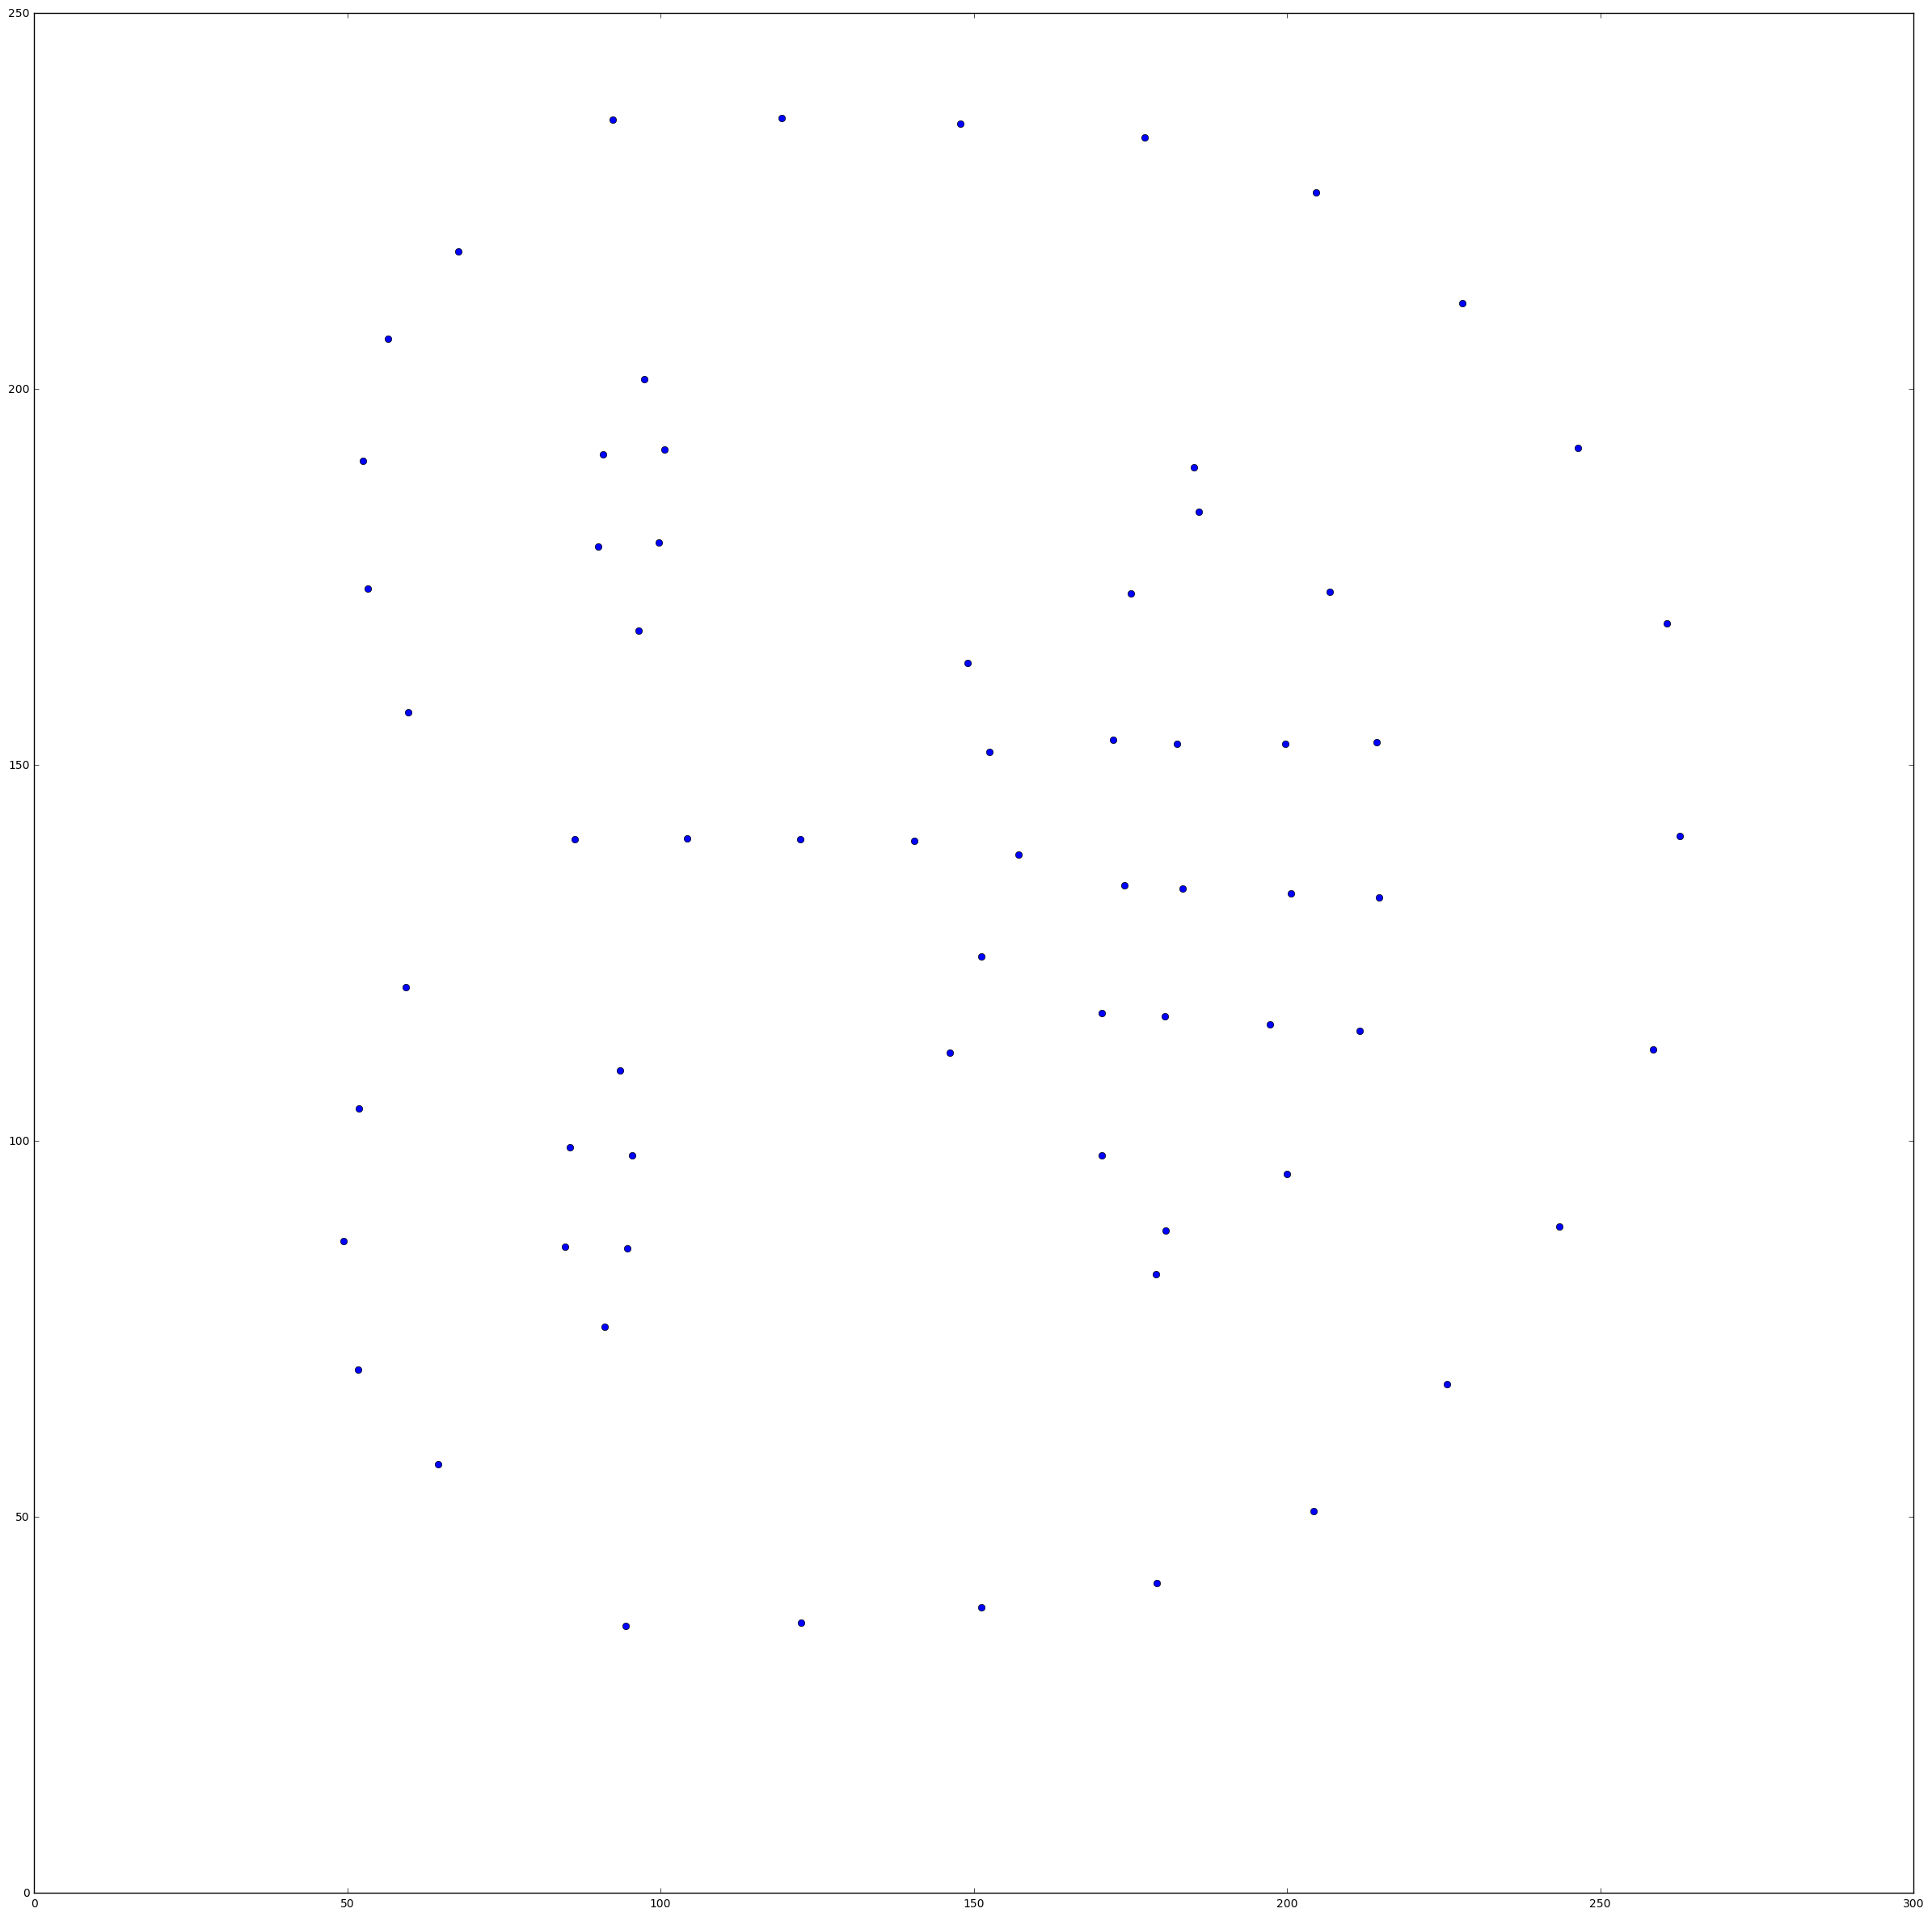

In [8]:
from menpowidgets import visualize_images
import matplotlib.pyplot as plt
%matplotlib inline
data_normalize = x_training + x_testing

path_to_test_images = "/home/lee/workspace/GR/test-images/**/**/**/*"
test_images = mio.import_images(path_to_test_images, verbose=True)
test_images = test_images.map(process)

landmark_neutral = test_images[0].landmarks['PTS'].lms.points
landmark_perk = test_images[1].landmarks['PTS'].lms.points
landmark_perk = normalize_perk_landmark(landmark_perk, landmark_neutral)
landmark = []

# visualize_images(test_images[4])

x = []
y = []
plt.figure(figsize=(30,30))
for point in landmark_perk:
    x.append(point[0])
    y.append(point[1])
plt.plot(x,y, 'bo')
# plt.gca().invert_yaxis()
plt.show()

# for i in range(0,68):
#     landmark.append(landmark_perk[i][0] - landmark_neutral[i][0])
#     landmark.append(landmark_perk[i][1] - landmark_neutral[i][1])
    
# print(coopNormalize(data_normalize, [landmark])[0])
# print(clf.predict([coopNormalize(data_normalize, [landmark])[0]]))

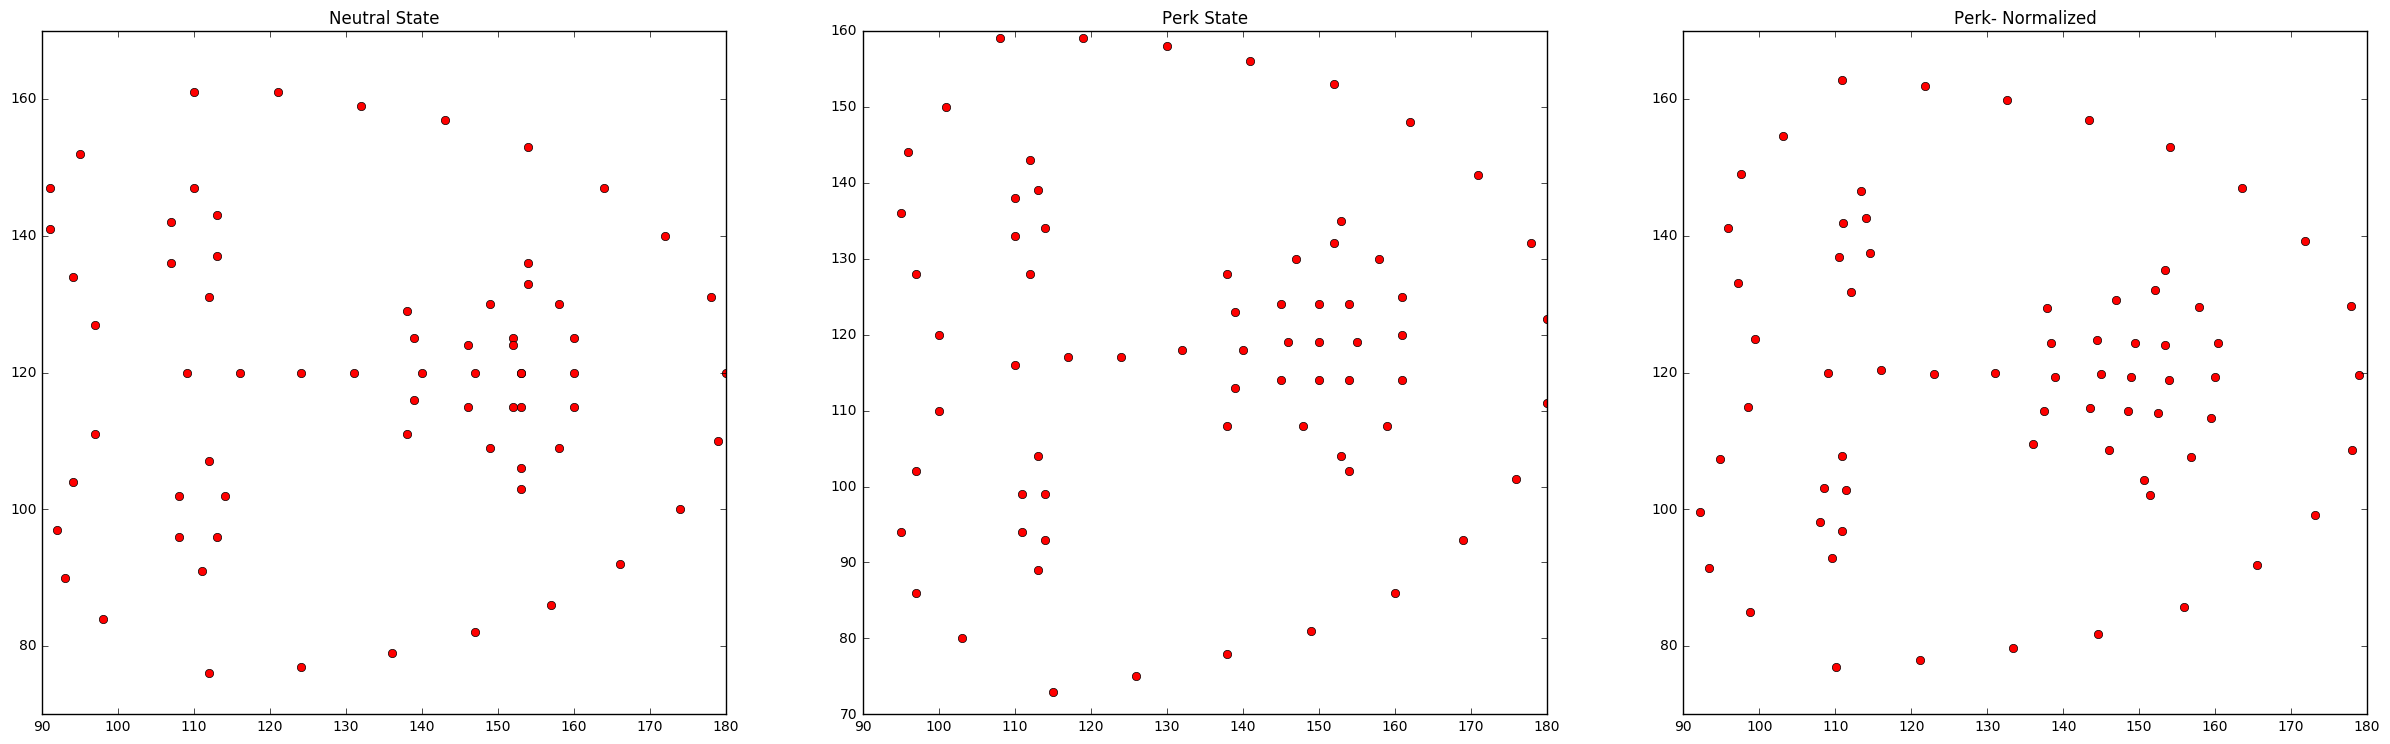

In [29]:
#process data sent from app
base_data = [76, 112, 77, 124, 79, 136, 82, 147, 86, 157, 92, 166, 100, 174, 110, 179, 120, 180, 131, 178, 140, 172, 147, 164, 153, 154, 157, 143, 159, 132, 161, 121, 161, 110, 84, 98, 90, 93, 97, 92, 104, 94, 111, 97, 127, 97, 134, 94, 141, 91, 147, 91, 152, 95, 120, 109, 120, 116, 120, 124, 120, 131, 111, 138, 116, 139, 120, 140, 125, 139, 129, 138, 91, 111, 96, 108, 102, 108, 107, 112, 102, 114, 96, 113, 131, 112, 136, 107, 142, 107, 147, 110, 143, 113, 137, 113, 103, 153, 109, 149, 115, 146, 120, 147, 124, 146, 130, 149, 136, 154, 130, 158, 125, 160, 120, 160, 115, 160, 109, 158, 106, 153, 115, 152, 120, 153, 125, 152, 133, 154, 124, 152, 120, 153, 115, 153]
landmark_data = [73, 115, 75, 126, 78, 138, 81, 149, 86, 160, 93, 169, 101, 176, 111, 180, 122, 180, 132, 178, 141, 171, 148, 162, 153, 152, 156, 141, 158, 130, 159, 119, 159, 108, 80, 103, 86, 97, 94, 95, 102, 97, 110, 100, 120, 100, 128, 97, 136, 95, 144, 96, 150, 101, 116, 110, 117, 117, 117, 124, 118, 132, 108, 138, 113, 139, 118, 140, 123, 139, 128, 138, 89, 113, 94, 111, 99, 111, 104, 113, 99, 114, 93, 114, 128, 112, 133, 110, 138, 110, 143, 112, 139, 113, 134, 114, 102, 154, 108, 148, 114, 145, 119, 146, 124, 145, 130, 147, 135, 153, 130, 158, 125, 161, 120, 161, 114, 161, 108, 159, 104, 153, 114, 150, 119, 150, 124, 150, 132, 152, 124, 154, 119, 155, 114, 154]




landmark_neutral = []
landmark_perk = []
landmarkChange = []

for i in range (0,68):
    landmark_neutral.append([base_data[2*i], base_data[2*i+1]])
    landmark_perk.append([landmark_data[2*i], landmark_data[2*i+1]])
x = []
y = []
# print(result.image.height)
# plt.figure(figsize=(10,10))
# test_images[0].landmarks['PTS'].lms.points

# plt.figure(figsize=(10,10))
# x = []
# y = []
# for point in landmark_neutral:
#     x.append(point[1])
#     y.append(point[0])
# plt.plot(x,y, 'bo')
plt.figure(figsize=(30,30))
plt.subplot(331)
x = []
y = []
# landmark_perk = normalize_perk_landmark(landmark_neutral, landmark_perk)
for lm in landmark_neutral:
    x.append(lm[1])
    y.append(lm[0])
plt.gca().set_title('Neutral State')
plt.plot(x,y, 'ro')

plt.subplot(332)
x = []
y = []
for point in landmark_perk:
    x.append(point[1])
    y.append(point[0])
plt.gca().set_title('Perk State')
plt.plot(x,y, 'ro')


plt.subplot(333)
x = []
y = []
landmark_perk = normalize_perk_landmark(landmark_perk, landmark_neutral)
for point in landmark_perk:
    x.append(point[1])
    y.append(point[0])
plt.gca().set_title('Perk- Normalized')
plt.plot(x,y, 'ro')


plt.show()

In [57]:
landmark = [11, -1, 12, -3, 11, -5, 12, -5, 13, -6, 15, -7, 15, -7, 14, -5, 14, -5, 13, -8, 12, -10, 11, -10, 10, -11, 10, -10, 9, -11, 5, -10, 4, -10, 11, 0, 9, 1, 6, -1, 6, -2, 4, -3, 3, -5, 2, -7, 2, -6, 2, -5, 1, -4, 4, -6, 5, -6, 6, -6, 7, -6, 6, -10, 7, -11, 9, -10, 9, -12, 11, -12, 11, -2, 9, 0, 8, -1, 7, -5, 9, -6, 11, -5, 3, -7, 2, -4, 0, -5, 0, -7, 0, -8, 2, -8, 3, -20, 4, -17, 6, -16, 9, -18, 11, -18, 15, -22, 17, -24, 16, -16, 14, -12, 11, -11, 8, -11, 5, -12, 2, -19, 6, -20, 10, -20, 11, -21, 17, -23, 13, -10, 11, -9, 7, -9]    

print(coopNormalize(data_normalize, [landmark])[0])
print(clf.predict([coopNormalize(data_normalize, [landmark])[0]]))

[ 0.40155916 -0.04348336  0.35855929 -0.13134877  0.24533861 -0.23740306
  0.21895512 -0.23838482  0.20091202 -0.31656364  0.19611243 -0.37686233
  0.17315666 -0.44715282  0.14392976 -0.40448495  0.14227931 -0.33623242
  0.14306913 -0.36970702  0.14923109 -0.40034688  0.15918669 -0.34897041
  0.16957232 -0.33906189  0.18962737 -0.2828835   0.1952423  -0.29600268
  0.13000389 -0.26976319  0.13223855 -0.27221893  0.69270259  0.
  0.55900654  0.04718253  0.38500137 -0.05087038  0.34009082 -0.11492574
  0.22025947 -0.19242203  0.16436945 -0.37575435  0.12943724 -0.36546687
  0.13599742 -0.24588012  0.14835827 -0.18212193  0.08077536 -0.13501534
  1.         -1.35699677  1.         -1.90829894  1.         -2.68955879
  1.         -6.          0.26488093 -1.34575685  0.30906092 -2.29402621
  0.39107482 -1.2229923   0.40412825 -1.06946452  0.51001863 -0.70464706
  1.         -0.12235544  0.65899785  0.          0.62848284 -0.10043953
  0.7572216  -0.46940304  0.78983846 -0.55881021  0.894711 

In [16]:
#save model
# save_object(models, 'models/au_models.pkl')
#save_object(facs, '/Programing/GR/Code/Python/models/facs.pkl')
save_object(clf, 'models/emotion_model.pkl')
# save_object(x_training + x_testing, 'models/normalize_data.pkl')